# Answers

You can edit this Jupyter notebook to include your answers and run any code that generates those answers or produces plots.  You can add additional cells for code or markdown as needed.

This homework is primarily about running simulations involving initial value problems (IVPs) and a simple PDE.

In [1]:
import math

import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
from scipy.integrate import DenseOutput
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.sparse as sparse
from sympy import Function, dsolve, Eq, Derivative, sin, cos, symbols
from scipy.integrate import solve_ivp
import importlib
from scipy.sparse import diags
from scipy.sparse.linalg import splu
from euler import ForwardEuler
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## Problem 0 (30 points)

In this problem, you will implement a custom ODE solver for `solve_ivp` based on the Forward Euler method, and implement some basic tests.

### Part A (20 points)
If you read the [documentation for `solve_ipv`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html), which we used in class, you'll see that you can write your own solver.

Write a solver for the forward Euler method, which is not implemented as one of the available solvers (while simple, it typically is not very accurate).  Recall, this is the basic rule:
\begin{equation}
y(t + h) = y(t) + h f(t, y)
\end{equation}

Your solver should be a class which is derived from [`scipy.integrate.OdeSolver`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.OdeSolver.html#scipy.integrate.OdeSolver)
```python
class ForwardEuler(scipy.integrate.OdeSolver):
    pass
```

Your class definition should go in [`euler.py`](euler.py)

You should read the documentation for this base class in order to implement `ForwardEuler`.  Here are some hints/notes:
* Allow a user to set `h` using a keyword argument.  This can be passed using `solve_ivp(..., method=ForwardEuler, h=0.01)` to set `h=0.01`
* Use a default step size `h = (t_bound - t0) / 100`
* private methods begin with an underscore "_"
* the method `_dense_output_impl(self)` should output a `ForwardEulerOutput` (defined in [`euler.py`](euler.py))
* direction should be `+1`
* You won't use a Jacobian, so `njev` and `nlu` can remain at 0.
* You may want to consider using `super(ForwardEuler, self).__init__`
* You may want to read the source code for the parent class [here](https://github.com/scipy/scipy/blob/v1.5.3/scipy/integrate/_ivp/base.py#L25-L214)

---

*put any discussion here*

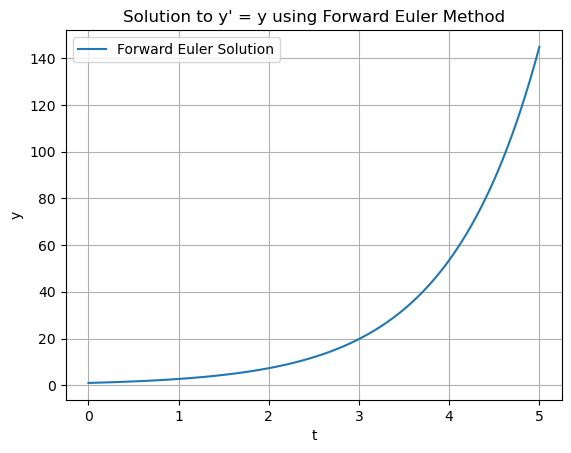

In [2]:
from euler import ForwardEuler
from sympy.abc import x # x is overwritten in previous cells so we need to import here

# Define the initial value problem dy/dt = y
def dy_dt(t, y):
    return y

# Solve the IVP using ForwardEuler with a dense output
sol = solve_ivp(dy_dt, [0, 5], [1], method=ForwardEuler, h=0.01, dense_output=True)

# Plotting result
t_vals = np.linspace(0, 5, 100)  # time from [0,5] with 100 points
y_vals = sol.sol(t_vals)  # Evaluate solution at sampled points
plt.plot(t_vals, y_vals.T, label="Forward Euler Solution")  # Transpose for correct shape
plt.xlabel('t')
plt.ylabel('y')
plt.title("Solution to y' = y using Forward Euler Method")
plt.legend()
plt.grid(True)
plt.show()

### Part B (10 points)

Use your `ForwardEuler` solver and `solve_ivp` to solve an IVP $y'(t) = y$ with $y(0) = 1$ on the domain $t\in [0,5]$, using a step size `h=0.01`.  Make a plot of the solution to this IVP with axes labeled `y` and `x`.

Use SymPy to obtain the ground-truth solution to this IVP.  What is the largest error you see on the domain you solved the problem?  Try solving with the default solver in `solve_ivp`.  What is the largest error in this case?

---

*put your answers here*

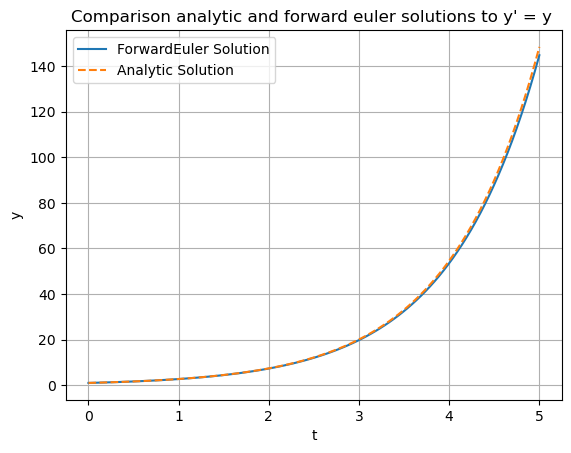

max euler error =  3.6403866699945127
max scipy error =  0.058598275446342996


In [3]:
# Define IVP 
def dy_dt(t, y):
    return y

y0 = [1]
domain_t = [0,5]
h = 0.01

# solve y' =y by forward euler
solve_euler = solve_ivp(dy_dt, domain_t, y0, method = ForwardEuler, h=h, dense_output=True)

# plot forward euler solution
t_vals = np.linspace(domain_t[0], domain_t[-1], 100)
y_euler = solve_euler.sol(t_vals)
plt.plot(t_vals, y_euler.T, label="ForwardEuler Solution")

# plot y = e^t, analytic solution 
y_true = np.exp(t_vals)
plt.plot(t_vals, y_true.T, '--',label="Analytic Solution")

plt.xlabel('t')
plt.ylabel('y')
plt.title("Comparison analytic and forward euler solutions to y' = y ")
plt.legend()
plt.grid(True)
plt.show()

# maximum error of euler method
error_euler = abs(y_euler - y_true)
max_error_euler = max(error_euler.flatten())
print("max euler error = ", max_error_euler)

## solve IVP by scipy solve_ivp with default setting
sol_default = solve_ivp(dy_dt, domain_t, y0, dense_output=True)
y_default = sol_default.sol(t_vals)

# 
error_default = abs(y_default - y_true)
max_error_default = max(error_default.flatten())
print("max scipy error = ", max_error_default)

### Part C (optional challenge)

Use Richardson (see Problem 0) on your Forward Euler solver. How does the error change? You can assume that $m=1$ and derive the formula analytically. What happens if you do Richardson twice?

Maximum error of Richardson extrapolation: 0.0346803129185389


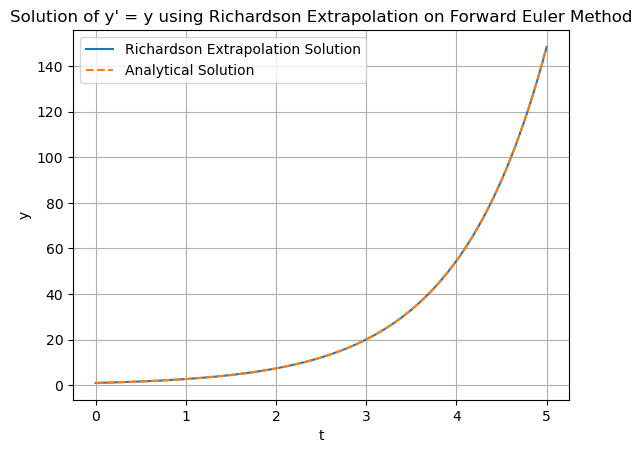

Maximum error after applying Richardson extrapolation twice: 0.0004495078376010042


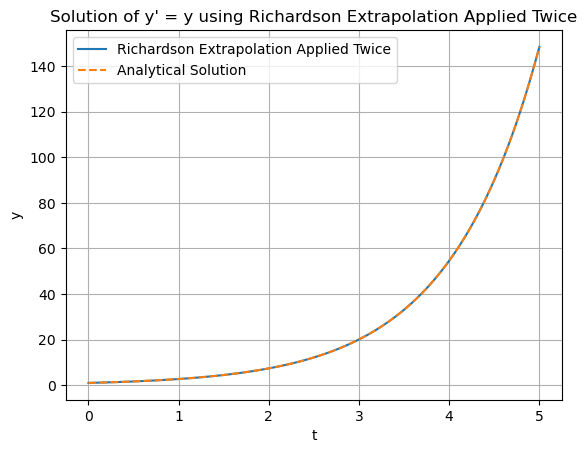

In [4]:
# Step sizes
h1 = h        # Original step size
h2 = h / 2    # Smaller step size

# Solve using step size h
sol_h1 = solve_ivp(dy_dt, domain_t, y0, method=ForwardEuler, h=h1, dense_output=True)
y_h1 = sol_h1.sol(t_vals)

# Solve using step size h/2
sol_h2 = solve_ivp(dy_dt, domain_t, y0, method=ForwardEuler, h=h2, dense_output=True)
y_h2 = sol_h2.sol(t_vals)

# Apply Richardson extrapolation
# For Euler's method, the error is proportional to h in global i.e error is O(h + O(h^2))  O(h^2) is local error 
# y_h = y_t + Ch + O(h^2)
# y_h/2 = y_t + C*h/2 + O(h^2)
# y_richardson = y_h2 + (y_h2 - y_h1) / (2^1 - 1) = 2 * y_h2 - y_h1 + O(h^2)
y_richardson = 2 * y_h2 - y_h1

# Calculate the true solution
y_true = np.exp(t_vals)

# Calculate errors
error_richardson = np.abs(y_richardson - y_true)
max_error_richardson = np.max(error_richardson.flatten())
print(f'Maximum error of Richardson extrapolation: {max_error_richardson}')

# Plot the numerical solution after Richardson extrapolation
plt.plot(t_vals, y_richardson.T, label='Richardson Extrapolation Solution')

# Plot the analytical solution for comparison
plt.plot(t_vals, y_true, '--', label='Analytical Solution')

plt.xlabel('t')
plt.ylabel('y')
plt.title("Solution of y' = y using Richardson Extrapolation on Forward Euler Method")
plt.legend()
plt.grid(True)

plt.show()

# Solve using step size h/4
h3 = h2 / 2
sol_h3 = solve_ivp(dy_dt, domain_t, y0, method=ForwardEuler, h=h3, dense_output=True)
y_h3 = sol_h3.sol(t_vals)

# First Richardson extrapolation (already done)
# y_richardson_1 = 2 * y_h2 - y_h1

# Second Richardson extrapolation
# y_richardson_2 = 2 * y_h3 - y_h2

# Apply Richardson extrapolation between y_richardson_1 and y_richardson_2
# For the improved estimates, the error is now proportional to h^2, so we use:
# y_richardson_twice = y_richardson_2 + (y_richardson_2 - y_richardson_1) / (2^2 - 1)
# Since the error decreases quadratically, the factor is (2^2 - 1) = 3
y_richardson_1 = 2 * y_h2 - y_h1
y_richardson_2 = 2 * y_h3 - y_h2
y_richardson_twice = (4 * y_richardson_2 - y_richardson_1) / (4 - 1)

# Calculate errors
error_richardson_twice = np.abs(y_richardson_twice.flatten() - y_true)
max_error_richardson_twice = np.max(error_richardson_twice)
print(f'Maximum error after applying Richardson extrapolation twice: {max_error_richardson_twice}')

# Plot the numerical solution after Richardson extrapolation applied twice
plt.plot(t_vals, y_richardson_twice.T, label='Richardson Extrapolation Applied Twice')

# Plot the analytical solution for comparison
plt.plot(t_vals, y_true, '--', label='Analytical Solution')

plt.xlabel('t')
plt.ylabel('y')
plt.title("Solution of y' = y using Richardson Extrapolation Applied Twice")
plt.legend()
plt.grid(True)
plt.show()


## Problem 1 (20 points)

Now that you're warmed up, here are some more simulations.

### Part A (15 points)

In this problem, we'll simulate a planet and moon moving in a 2-dimensional plane.

Newton's law of gravity says that $F_g = Gm_1 m_2 / \|r\|^2$.  The direction of the force is in the direction of the vector $r$.  Let $x(t)$ dentote the position of the planet and $y(t)$ denote the position of the moon, and $r(t) = x(t) - y(t)$ Then
\begin{equation}
x''(t) = -F_g / m_1 \times r / \|r\|\\
y''(t) = F_g / m_2 \times r / \|r\|
\end{equation}
$x$ and $y$ are 2-vectors, so this is a system of 4-second order ODEs.  We can use the following trick to write this as 8 first order ODEs. Let $p(t)$ be the velocity of the planet and $q(t)$ be the velocity of the moon (note that they are vector valued!). So, $p(t) = x'(t)$, and $q(t) = y'(t)$.  Here are the terms for $x$:
\begin{equation}
p_1'(t) = -F_g / m_1 \times r_1(t) / \|r\|\\
p_2'(t) = -F_g / m_1 \times r_2(t) / \|r\|\\
x_1'(t) = p_1(t)\\
x_2'(t) = p_2(t)
\end{equation}
\begin{equation}
q_1'(t) = F_g / m_2 \times r_1(t) / \|r\|\\
q_2'(t) = F_g / m_2 \times r_2(t) / \|r\|\\
y_1'(t) = q_1(t)\\
y_2'(t) = q_2(t)
\end{equation}

We'll model the Earth and moon.  The [Gravitational constant](https://en.wikipedia.org/wiki/Gravitational_constant) has value `G=6.67 e-11` (we're dropping units, which are all SI).  The mass of the earth is `m1 = 5.972 e24`, and the mass of the moon is `m2=0.07346 e24`.  The distance from the moon to the earth is `r = 384.4 e6`.  This means the orbital speed of the moon around the earth is about `1.022 e3`.

Use `solve_ivp` to run a simulation of the moon orbiting the earth for `5 e6` seconds (about 2 months).  Use initial conditions $x(0) = 0, p(0) = 0$ for the earth, and $y(0) = (0, 384.4 \times 10^6)$ and $q(0) = (1.022 \times 10^3, 0)$

Plot $x_1(t), x_2(t)$ and $y_1(t), y_2(t)$ in the same plane with different colors (include a legend and title).

---

*Put any answers/discussion here*

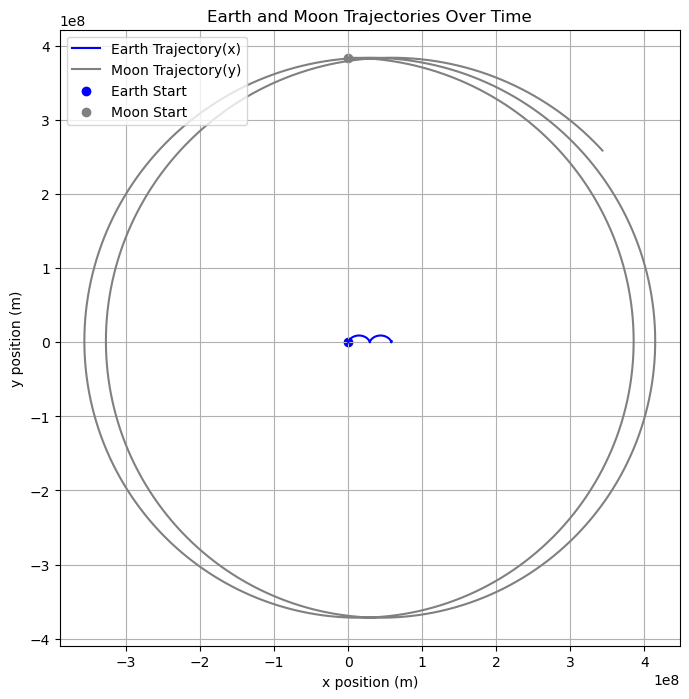

In [5]:
# all distance use Meter; Speed use Meter/second; Mass use Kg; Time yse second
# Initialize constants needed
G = 6.67e-11  # m^3 kg^-1 s^-2
m1 = 5.972e24      # Mass of the Earth
m2 = 0.07346e24    # Mass of the Moon
# Initial positions (in meters)
x0 = np.array([0.0, 0.0])  # Earth at the origin
y0 = np.array([0.0,  384.4e6])  # Moon at distance r=384.4e6 along y-axis

# Initial velocities (in meters per second)
p0 = np.array([0.0, 0.0])       # Earth at rest
q0 = np.array([1.022e3, 0.0])  # Moon's initial velocity along x-axis

# Time span for the simulation (in seconds)
domain_t = (0, 5e6)     # Simulate for 5 million seconds

# Initial state vector
initial_state = np.concatenate([x0, p0, y0, q0])

def earth_moon_system(t, state):
    # Unpack the state vector
    x = state[0:2]  # Position of Earth
    p = state[2:4]  # Velocity of Earth
    y = state[4:6]  # Position of Moon
    q = state[6:8]  # Velocity of Moon
    
    # Compute the vector from Moon to Earth
    r = x - y
    r_norm = np.linalg.norm(r)
    
    # Compute the gravitational force magnitude
    Fg = G * m1 * m2 / r_norm**2
    
    # Compute the acceleration components
    # Direction of the force is along r (from Moon to Earth)
    # For Earth
    p_dot = -Fg / m1 * r / r_norm
    x_dot = p  # Earth's velocity
    
    # For Moon
    q_dot = Fg / m2 * r / r_norm
    y_dot = q  # Moon's velocity
    
    # Combine derivatives into a single vector
    derivatives = np.concatenate([x_dot, p_dot, y_dot, q_dot])
    return derivatives

# Time evaluation points (optional)
t_eval = np.linspace(domain_t[0], domain_t[1], 1000)

# Solve the system
solution = solve_ivp(
    earth_moon_system,
    domain_t,
    initial_state,
    method='RK45',  # Default method
    t_eval=t_eval,
    rtol=1e-8,
    atol=1e-10
)

# Extract positions
x_sol = solution.y[0:2, :]  # Earth's position over time
y_sol = solution.y[4:6, :]  # Moon's position over time

# Plotting the trajectories
plt.figure(figsize=(8, 8))
plt.plot(x_sol[0], x_sol[1], label='Earth Trajectory(x)', color='blue')
plt.plot(y_sol[0], y_sol[1], label='Moon Trajectory(y)', color='gray')

# Mark initial positions
plt.scatter(x0[0], x0[1], color='blue', marker='o', label='Earth Start')
plt.scatter(y0[0], y0[1], color='gray', marker='o', label='Moon Start')

plt.xlabel('x position (m)')
plt.ylabel('y position (m)')
plt.title('Earth and Moon Trajectories Over Time')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.grid(True)
plt.show()


### Part B (5 points)

Now simulate a system with 10 planets, in 10 random locations. The planets should have random masses chosen independently and uniformly from the interval $[0,6 \times 10^{24}]$ and initial locations chosen randomly from the $(8 \times 10^8) \times (8\times 10^8)$ square centered at the origin. The components of each planet's initial velocity should be chosen randomly on $[-5\times 10^{2}, 5 \times 10^{2}].$ Plot the positions of each planet as a function of time.

---

*Your answer here.  You can create some code cells as well*

In [6]:
# Gravitational constant
G = 6.67e-11  # m^3 kg^-1 s^-2

# Number of planets
num_planets = 10

# Random masses between 0 and 6e24 kg
masses = np.random.uniform(0, 6e24, num_planets)

# Since position and velocities will be used in n_body system function, the following is _out
# Random initial positions within a square of size 8e8 m centered at the origin
positions_out = np.random.uniform(-4e8, 4e8, (num_planets, 2))

# Random initial velocities between -5e2 and 5e2 m/s
velocities_out = np.random.uniform(-5e2, 5e2, (num_planets, 2))

# Time span for the simulation
domain_t = (0, 5e6)  # Simulate for 5 million seconds

# Initial state vector
initial_state = np.concatenate([positions_out.flatten(), velocities_out.flatten()])

In [7]:
def n_body_system(t, state):
    # Unpack positions and velocities
    positions = state[:2*num_planets].reshape((num_planets, 2))
    velocities = state[2*num_planets:].reshape((num_planets, 2))
    
    # Initialize derivatives
    pos_dot = np.zeros_like(positions)
    vel_dot = np.zeros_like(velocities)
    
    # Update positions derivatives (velocities)
    pos_dot = velocities
    
    # Compute acceleration for each planet
    for i in range(num_planets):
        # Initialize force
        total_force = np.zeros(2)
        for j in range(num_planets):
            if i != j:
                # Vector from planet j to planet i
                r = positions[i] - positions[j]
                r_norm = np.linalg.norm(r)
                if r_norm > 1e3:  # Avoid division by zero or very small distances
                    # Gravitational force magnitude
                    F = G * masses[i] * masses[j] / r_norm**2
                    # Force vector
                    total_force -= F * r / r_norm  # Negative because gravity is attractive
        # Acceleration
        vel_dot[i] = total_force / masses[i]
    
    # Combine derivatives
    derivatives = np.concatenate([pos_dot.flatten(), vel_dot.flatten()])
    return derivatives

In [8]:
# Time evaluation points
t_eval = np.linspace(domain_t[0], domain_t[1], 1000)

# Solve the system
solution = solve_ivp(
    n_body_system,
    domain_t,
    initial_state,
    t_eval=t_eval,
    rtol=1e-6,
    atol=1e-8
)

# Extract positions over time
positions_over_time = solution.y[:2*num_planets, :].reshape((num_planets, 2, -1))

# Plot trajectories of each planet
plt.figure(figsize=(10, 10))

colors = plt.cm.jet(np.linspace(0, 1, num_planets))

<Figure size 1000x1000 with 0 Axes>

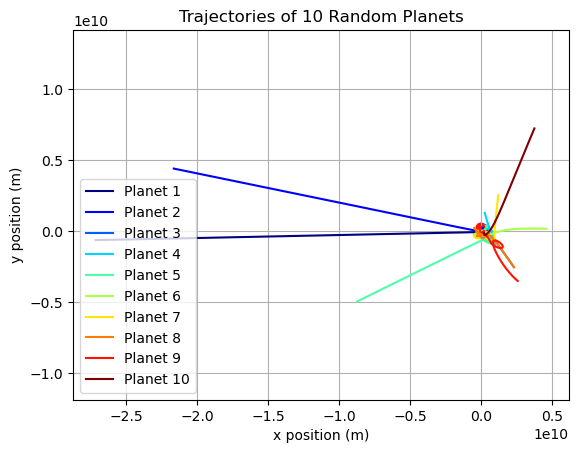

In [9]:
for i in range(num_planets):
    plt.plot(
        positions_over_time[i, 0, :],
        positions_over_time[i, 1, :],
        label=f'Planet {i+1}',
        color=colors[i]
    )
    # Mark initial positions
    plt.scatter(
        positions_out[i, 0],
        positions_out[i, 1],
        color=colors[i],
        marker='o'
    )

plt.xlabel('x position (m)')
plt.ylabel('y position (m)')
plt.title('Trajectories of 10 Random Planets')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


## Problem 2 (30 points)
In this problem, we will solve some a simple PDE using the "method of lines". In this method, we replace the
$$\partial_t u(t,x) = \Delta u(t,x) $$
PDE by the system of ODEs
$$ \partial_t\boldsymbol{u}(t) = A \boldsymbol{u}(t),$$
where
$$[\boldsymbol{u}(t)]_i=u_i(t) \approx u(t,x_i). $$
The matrix $A$ approximates the differential operator using, e.g. finite differences
$$ \Delta u \to A \boldsymbol{u}.$$

After we semi-discretize in space we are left with a large system of ODEs that we can solve using our favorite method.
 

### Part A (25 points)
In this problem we will solve the heat equation 
\begin{equation}
\begin{cases}
\partial_t u(t,x) = \Delta u(t,x) & x\in [0,1], \;t\in[0,T]\\
u(0,x) = f(x) & x\in [0,1]\\
u(t,0) = a & t \in [0,T]\\
u(t,1) = b & t \in [0,T]\\
\end{cases}
\end{equation}
with the method of lines.

To solve this equation, we discretize the interval $x\in[0,1]$ with $n+2$ points. The end points will be used to enforce boundary conditions and the interior points will be used to compute the right hand side of the PDE. We approximate the Laplacian operator using the second order centered difference formula
$$g''(x) = \frac{g(x+h)-2g(x)+g(x-h)}{h^2}$$
and we integrate in time using the forward Euler method.

Your code for implementing this method should include the following three functions
1. `second_diff`, which computes the second derivative of $u$ at the interior nodes (using the centered difference formula) and returns it as an array with zeros on each end (as the boundary conditions don't change)
2. `forward_time_step`, which uses $u(t_n,x)$ and the forward Euler method to compute $u(t_{n+1},x)$
3. `sim_heat`, which solves the heat equation by setting $u(0,x)=f(x)$ and then calling `forward_time_step` repeatedly to compute $u(T,x)$. This function should accept the following inputes
    * `n` the number of internal nodes 
    * `f` the initial condition
    * `bc` a list containing the left and right boundary conditions $a$ and $b$
    * `dx` the grid spacing, i.e. the distance between x values i.e. $1/(n+1)$
    * `dt` the time step to be used by the forward Euler method
    * `T` the time at which we want the solution $u(T,x)$. Note that in general $T/dt$ will not be an integer, so the last call of `forward_time_step` will have to use a smaller time step than `dt`

Once you have created these functions, solve the heat equation with
\begin{gather}
f(x) = \sin(2\pi x)\\
a = b = 0
\end{gather}
up until time $T=0.02$ using $n=99$ and `dt=0.2*dx**2`. 

To verify the accuracy of your code, compare the output to the exact solution $u(t,x)= \exp(-4\pi^2t)\sin(2\pi x)$. You can do this by summing the sum of squares errors at your $x_i$'s and dividing by $\sqrt{n}$.

You should also include a plot of $u(0,x)$ and $u(T,x)$.

In [10]:
def second_diff(u, dx):
    """
    Compute the second derivative of u at interior nodes using the centered difference formula.
        g''(x) = (g(x+h) - 2g(x) + g(x-h))/h^2
        
    Parameters:
        
    - u: function
    - dx: step size
    
     Returns:
         
    - u_xx: an array of the same length as u, with zeros at the boundaries.
    """
    u_xx = np.zeros_like(u)
    # Compute second derivative at interior nodes
    u_xx[1:-1] = (u[2:] - 2 * u[1:-1] + u[:-2]) / (dx**2)
    return u_xx

def time_step(u, dx, dt):
    """
    Perform a single forward Euler time step.
    Boundary conditions are assumed to be enforced externally (u[0] and u[-1]).
    """

    u_xx = second_diff(u, dx)
    u_new = u + dt * u_xx 
    # Enforce boundary conditions (keep u[0] and u[-1] unchanged)
    u_new[0] = u[0]
    u_new[-1] = u[-1]
    return u_new

def sim_heat(n, f, bc, dx, dt, T):
    """
    Simulate the heat equation up to time T using forward Euler method.
    
    Parameters:
    - n: number of internal nodes
    - f: function defining the initial condition f(x)
    - bc: list containing left and right boundary conditions [a, b]
    - dx: grid spacing
    - dt: time step
    - T: final time
    
    Returns:
    - x: array of spatial grid points
    - u: array of solution values at final time T
    """
    a, b = bc
    x = np.linspace(0, 1, n + 2)  # Including boundary points
    u = f(x)
    # to fill boundary elements
    u[0] = a  # Left boundary condition 
    u[-1] = b  # Right boundary condition
    t = 0.0
    while t < T:
        dt_eff = min(dt, T - t)
        u = time_step(u, dx, dt_eff)
        t += dt_eff
    return x, u


By problem
- $n=99$
- $d x=\frac{1}{n+1}$
- $d t=0.2 \times （d x^2$
- $T=0.02$
- Boundary conditions: $a=b=0$
- Initial condition: $f(x)=\sin (2 \pi x)$
- Exact solution: $u_{\text {exact }}(t, x)=e^{-4 \pi^2 t} \sin (2 \pi x)$

Sum of squared errors divided by sqrt(n): 1.676069245121626e-05


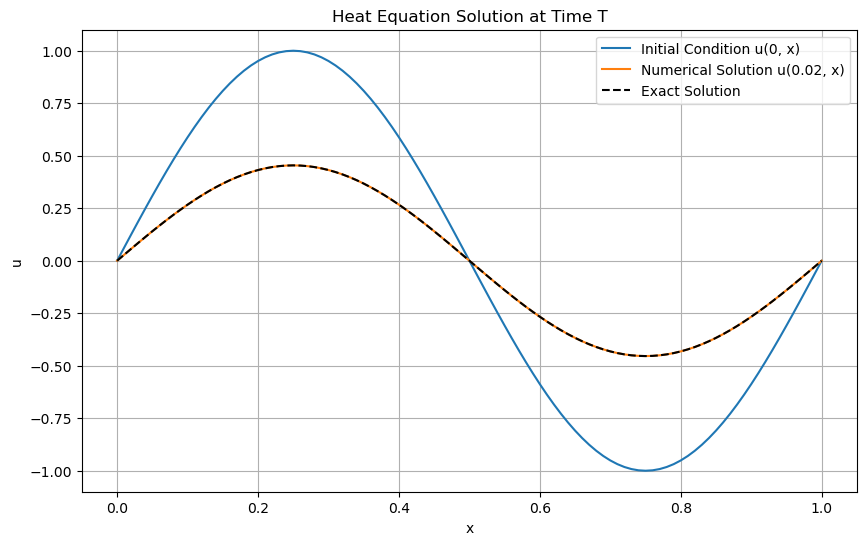

In [11]:

# Parameters
n = 99
dx = 1 / (n + 1)
dt = 0.2 * dx**2
T = 0.02
bc = [0, 0]  # boundary condition a = b = 0

# Initial condition function
def f(x):
    return np.sin(2 * np.pi * x)

# Exact solution function : e^(-4pi^2t)sin(2pix)
def u_exact(t, x):
    return np.exp(-4 * np.pi**2 * t) * np.sin(2 * np.pi * x)

# Run the simulation
x, u_numeric = sim_heat(n, f, bc, dx, dt, T)

# Compute the exact solution at final time T
u_true = u_exact(T, x)

# Compute the error
error = u_numeric - u_true
error_norm = np.linalg.norm(error[1:-1]) / np.sqrt(n)  # Exclude boundaries
print(f"Sum of squared errors divided by sqrt(n): {error_norm}")

# Plot the initial condition and numerical solution at time T
plt.figure(figsize=(10, 6))
plt.plot(x, f(x), label='Initial Condition u(0, x)')
plt.plot(x, u_numeric, label=f'Numerical Solution u({T}, x)')
plt.plot(x, u_true, 'k--', label='Exact Solution')
plt.xlabel('x')
plt.ylabel('u')
plt.title('Heat Equation Solution at Time T')
plt.legend()
plt.grid(True)
plt.show()



## Part B (5 points)
Now solve for $u(T,x)$ using the same parameters as above, except that you should set `dt=0.7*dx**2`. Create a plot of $u(0,x)$ and $u(T,x)$ and compare it to the plot from the previous question. The ratio $dt/dx^2$ is called the CFL (Courant–Friedrichs–Lewy) number and the observation that you will make is an important concept in numerical PDE methods.

Sum of squared errors with large dt divided by sqrt(n): 1.871676621123992e+56


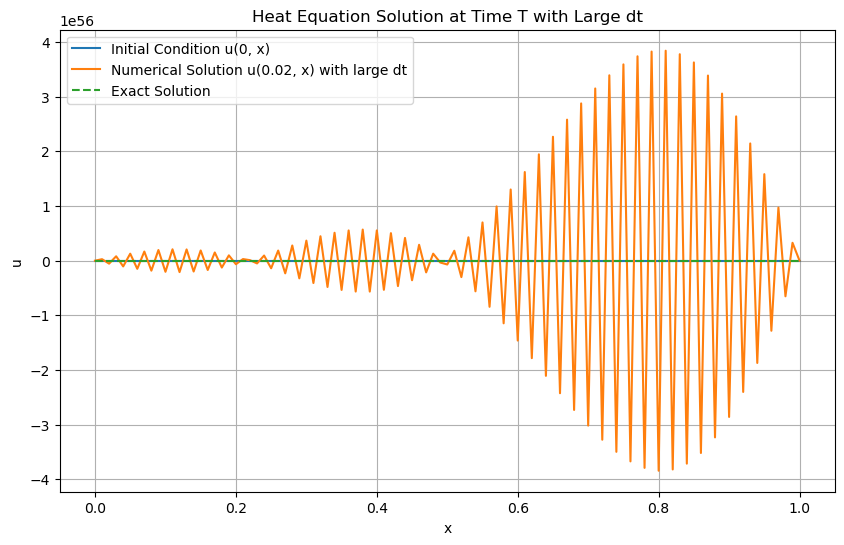

In [12]:
# New time step
dt_large = 0.7 * dx**2

# Run the simulation
x, u_numeric_large_dt = sim_heat(n, f, bc, dx, dt_large, T)

# Compute the exact solution at final time T
u_true = u_exact(T, x)

# Compute the error
error_large_dt = u_numeric_large_dt - u_true
error_norm_large_dt = np.linalg.norm(error_large_dt[1:-1]) / np.sqrt(n)
print(f"Sum of squared errors with large dt divided by sqrt(n): {error_norm_large_dt}")

# Plot the initial condition and numerical solution at time T with large dt
plt.figure(figsize=(10, 6))
plt.plot(x, f(x), label='Initial Condition u(0, x)')
plt.plot(x, u_numeric_large_dt, label=f'Numerical Solution u({T}, x) with large dt')
plt.plot(x, u_true, '--', label='Exact Solution')
plt.xlabel('x')
plt.ylabel('u')
plt.title('Heat Equation Solution at Time T with Large dt')
plt.legend()
plt.grid(True)
plt.show()


## Part C (optional, 5 bonus points)
The CFL condition that $dt/dx^2<0.5$ is prohibitively restrictive. To get around this, we can use so-called implicit time stepping schemes, which are far more stable, though computationally costly. The simplest of these schemes is the backwards Euler method:
$$ y(t_{n+1}) = y(t_n) + dt y'(t_{n+1})$$
(Note that $y'$ is now evaluated at a future time.) When solving a linear system of ODEs
$$ y'= A y$$
the backwards Euler method requires us to solve the linear system
$$ (I - dt A)y(t_{n+1}) = y(t_{n}). $$

In this problem you should modify your existing code to solve the heat equation using this implicit time stepping scheme. In order to do this efficiently, you should construct and store a Cholesky factorization of the matrix $I-dt A$.

With this new code, repeat the experiment from part B. Do you run into the same stability problem?

Further, with this method, are you able to make $dt$ a comparable size to $dx$?

According to the below the methd in part C is more stable and no stability happened. Yes we are able to make dt a comparable size to dx

Sum of squared errors with implicit method divided by sqrt(n): 0.0001806709346697728


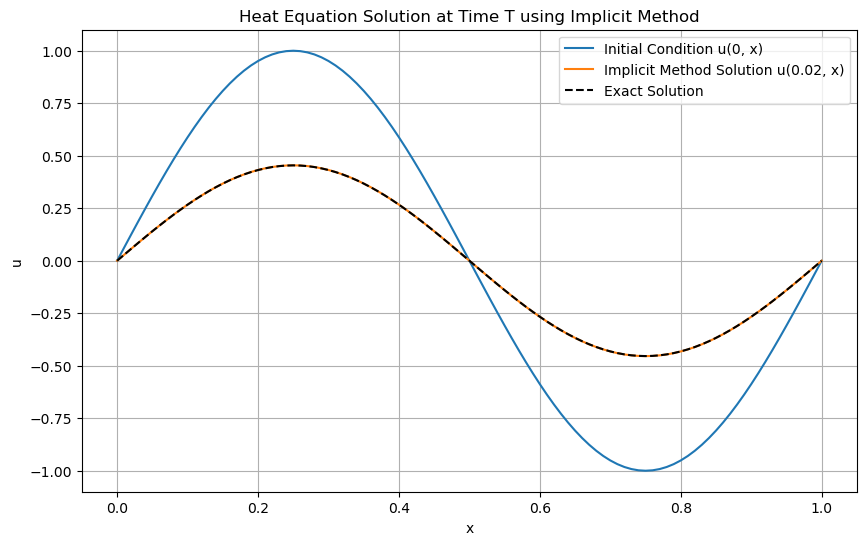

In [13]:
def sim_heat_implicit(n, f, bc, dx, dt, T):
    """
    Simulate the heat equation up to time T using the implicit backward Euler method.
    
    Parameters:
    - n: number of internal nodes
    - f: function defining the initial condition f(x)
    - bc: list containing left and right boundary conditions [a, b]
    - dx: grid spacing
    - dt: time step
    - T: final time
    
    Returns:
    - x: array of spatial grid points
    - u: array of solution values at final time T
    """
    a, b = bc
    x = np.linspace(0, 1, n + 2)  # Including boundary points
    u = f(x)
    u[0] = a  # Left boundary condition
    u[-1] = b  # Right boundary condition
    t = 0.0
    
    # Construct the matrix (I - dt * A)    
    main_diag = (1 + 2 * dt / dx**2) * np.ones(n)
    off_diag = (-dt / dx**2) * np.ones(n - 1)
    diagonals = [main_diag, off_diag, off_diag]
    A = diags(diagonals, [0, -1, 1]).tocsc()
    
    # Include boundary conditions
    # Since u[0] and u[-1] are fixed, we need to adjust the right-hand side accordingly
    
    # Precompute LU factorization
    lu = splu(A)
    
    while t < T:
        dt_eff = min(dt, T - t)
        # Adjust the matrix if dt changes (here dt is constant, so we skip this step)
        
        # Prepare the right-hand side
        rhs = u[1:-1]  # Interior nodes
        # Adjust for boundary conditions
        rhs[0] += (dt_eff / dx**2) * u[0]
        rhs[-1] += (dt_eff / dx**2) * u[-1]
        
        # Solve the linear system
        u_new_interior = lu.solve(rhs)
        
        # Update the solution
        u[1:-1] = u_new_interior
        t += dt_eff
    return x, u

# We'll use the same parameters as in Part B:
# Run the implicit simulation
x, u_numeric_implicit = sim_heat_implicit(n, f, bc, dx, dt_large, T)

# Compute the exact solution at final time T
u_true = u_exact(T, x)

# Compute the error
error_implicit = u_numeric_implicit - u_true
error_norm_implicit = np.linalg.norm(error_implicit[1:-1]) / np.sqrt(n)
print(f"Sum of squared errors with implicit method divided by sqrt(n): {error_norm_implicit}")

# Plot the initial condition and numerical solution at time T using implicit method
plt.figure(figsize=(10, 6))
plt.plot(x, f(x), label='Initial Condition u(0, x)')
plt.plot(x, u_numeric_implicit, label=f'Implicit Method Solution u({T}, x)')
plt.plot(x, u_true, 'k--', label='Exact Solution')
plt.xlabel('x')
plt.ylabel('u')
plt.title('Heat Equation Solution at Time T using Implicit Method')
plt.legend()
plt.grid(True)
plt.show()


## Feedback

If you would like share how long it took you to complete this assignment, it will help adjust the difficulty for future assignments.  You're welcome to share additional feedback as well.